In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [9]:
class FakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, out_neurons=2, theta_tau=1.0, sample_every=0.1):
        self.kappa = learning_rate
        self.omega = np.zeros((out_neurons, in_neurons))
        self.in_nrns = in_neurons
        self.theta = 0
        self.decay = np.exp(-0.001 / theta_tau)
        self.weight_history = []
        self.period = sample_every / 0.001

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        self.theta = out_rates * (1 - self.decay) + self.theta * self.decay
        self.omega += np.outer(self.kappa * out_rates * (out_rates - self.theta), in_rates)
        if (t / 0.001 % self.period) < 1:
            self.weight_history.append(self.omega)
        return np.dot(self.omega, in_rates)

In [17]:
with nengo.Network() as model:

    sin = nengo.Node(lambda t: np.sin(t * 4))

    pre_nrn = 4
    pre = nengo.Ensemble(pre_nrn, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.1, 0, 0, -0.1],
                         max_rates=[250, 300, 300, 250])

    post_nrn = 2
    post = nengo.Ensemble(post_nrn, 1, encoders=[[1], [-1]], intercepts=[-0.05, -0.05], max_rates=[200, 200])

    fake_bcm = FakeBCM(in_neurons=pre_nrn, out_neurons=post_nrn)
    learn = nengo.Node(fake_bcm.bcm_func, size_in=pre_nrn+post_nrn, size_out=post_nrn)

    nengo.Connection(sin, pre)

    nengo.Connection(pre.neurons, learn[:pre_nrn])
    nengo.Connection(post.neurons, learn[pre_nrn:])
    nengo.Connection(learn, post.neurons)

    p_nd = nengo.Probe(learn, synapse=0.01)
    p_in = nengo.Probe(pre, synapse=0.01)
    p_out = nengo.Probe(post, synapse=0.01)

In [18]:
with nengo.Simulator(model) as sim:
    sim.run(10)

A Jupyter Widget

A Jupyter Widget

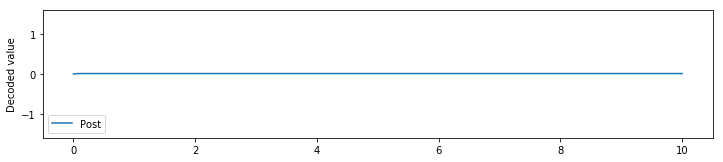

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

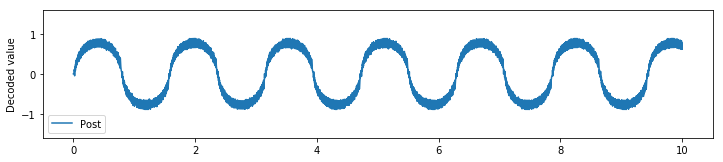

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_in], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

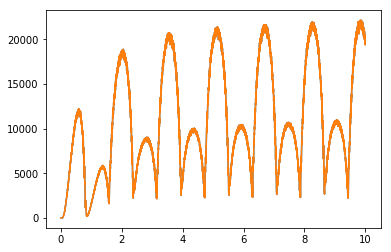

In [20]:
plt.plot(sim.trange(), sim.data[p_nd], label="Post")

In [21]:
sim.data[p_nd].shape

(10000, 2)